## EXPLORATORY DATA ANALYSIS

## 1. Importing required libraries and loading the dataset.

In [1]:
# Importing necessary libraries and setting up the data path
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from pathlib import Path
data_path = Path('../data/raw')
%matplotlib inline

In [2]:
# Loading the dataset
df = pl.read_csv(data_path / 'financial_news.csv')
print(f"Data Shape: {df.shape}")
print(f"First 10 rows:{df.head(10)}")


Data Shape: (8885, 6)
First 10 rows:shape: (10, 6)
┌────────┬──────────────────┬──────────────┬──────────────────┬──────────────────┬─────────────────┐
│ id     ┆ text             ┆ target       ┆ target_sentiment ┆ companies_sentim ┆ consumers_senti │
│ ---    ┆ ---              ┆ ---          ┆ ---              ┆ ent              ┆ ment            │
│ i64    ┆ str              ┆ str          ┆ str              ┆ ---              ┆ ---             │
│        ┆                  ┆              ┆                  ┆ str              ┆ str             │
╞════════╪══════════════════╪══════════════╪══════════════════╪══════════════════╪═════════════════╡
│ 69737  ┆ Renfe afronta    ┆ Renfe        ┆ negative         ┆ negative         ┆ negative        │
│        ┆ mañana un nuevo  ┆              ┆                  ┆                  ┆                 │
│        ┆ …                ┆              ┆                  ┆                  ┆                 │
│ 71795  ┆ Presupuesto      ┆ Presupuest

## 2. Analyzing dataset features.

In [3]:
# Displaying the schema of the DataFrame
print(df.schema)

Schema([('id', Int64), ('text', String), ('target', String), ('target_sentiment', String), ('companies_sentiment', String), ('consumers_sentiment', String)])


We use the column 'text' (string) as Predictor Variable.
For the Target Variable, we use the column 'target_sentiment' (categorical: positive, negative, neutral).
To make analysis easier, let's convert the 'target_sentiment' column to an integer.

In [4]:
# Selecting relevant columns for analysis
# For this project, we will focus on the 'text' and 'target_sentiment' columns.
relevant_columns = ['text', 'target_sentiment']
df = df.select(relevant_columns)
# Convert target_sentiment categories to integer labels
df = df.with_columns(
        pl.when(pl.col('target_sentiment') == 'positive').then(1)
        .when(pl.col('target_sentiment') == 'negative').then(0)
        .when(pl.col('target_sentiment') == 'neutral').then(2)
        .otherwise(None)
        .alias('target_sentiment')
        .cast(pl.Int32)
    )
df.head(5)

text,target_sentiment
str,i32
"""Renfe afronta mañana un nuevo …",0
"""Presupuesto populista con cimi…",0
"""Biden no cree que la OPEP+ vay…",0
"""La deuda de las familias cae e…",1
"""Bestinver: no hay ""momento más…",0


## 3. Plotting the selected features to understand the data distribution.

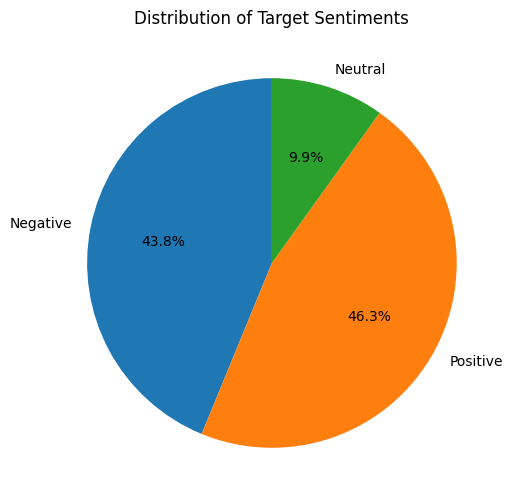

In [5]:
# Plotting the distribution of target sentiments 
value_counts_df = df['target_sentiment'].value_counts(normalize=True).sort('target_sentiment')
# Create mapping for labels
label_mapping = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
proportions = value_counts_df['proportion'].to_list()
sentiment_labels = [label_mapping.get(val, f'Unknown ({val})') for val in value_counts_df['target_sentiment'].to_list()]

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(proportions, labels=sentiment_labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Target Sentiments')
plt.show()

We have an imbalanced dataset, so this issue must be fixed to mitigate BIAS in the machine learning model training.

In [6]:
# Function to extract meaningful words from text data
def get_meaningful_words_spacy(texts, n=10):
    """Extract meaningful words using spaCy Spanish model"""
    try:
        import spacy
        nlp = spacy.load("es_core_news_sm")
        
        meaningful_words = []
        for text in texts:
            doc = nlp(text)
            # Extract only nouns, adjectives, and meaningful verbs
            for token in doc:
                if (not token.is_stop and 
                    not token.is_punct and 
                    len(token.text) > 2 and 
                    token.pos_ in ['NOUN', 'ADJ', 'VERB'] and
                    token.lemma_.isalpha()):
                    meaningful_words.append(token.lemma_.lower())
        
        return Counter(meaningful_words).most_common(n)
    except ImportError:
        print("Oh oh! Houston we got a problem. Check spaCy and the Spanish model installation.")        

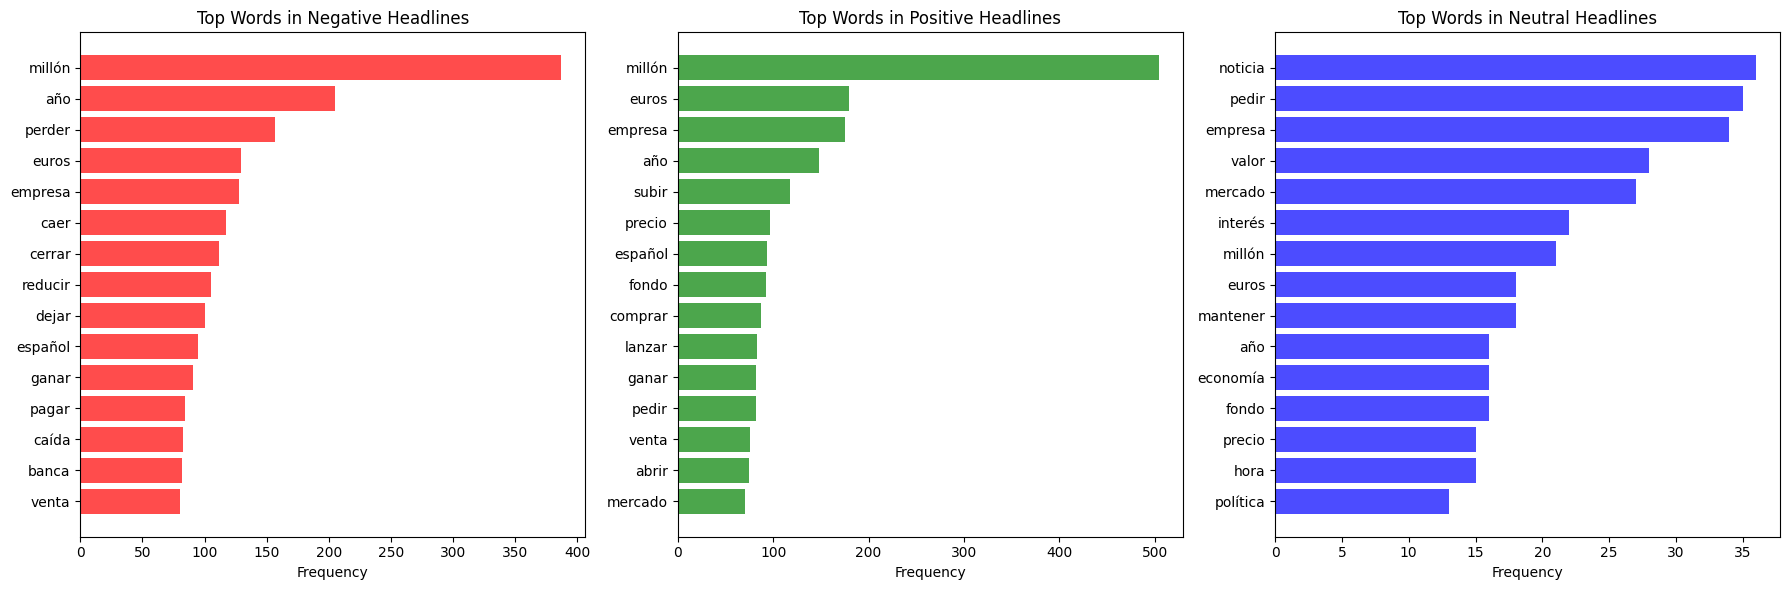

In [7]:
# Analyzing the text data
# Checking most common words in the text column by sentiment category
texts_by_sentiment = {}
for sentiment in [0, 1, 2]:
    texts = df.filter(pl.col('target_sentiment') == sentiment)['text'].to_list()
    texts_by_sentiment[sentiment] = texts

# Plot top words for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['red', 'green', 'blue']
sentiment_names = ['Negative', 'Positive', 'Neutral']

for i, sentiment in enumerate([0, 1, 2]):
    top_words = get_meaningful_words_spacy(texts_by_sentiment[sentiment], 15)   
    words, counts = zip(*top_words)    
    axes[i].barh(range(len(words)), counts, color=colors[i], alpha=0.7)
    axes[i].set_yticks(range(len(words)))
    axes[i].set_yticklabels(words)
    axes[i].set_title(f'Top Words in {sentiment_names[i]} Headlines')
    axes[i].set_xlabel('Frequency')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

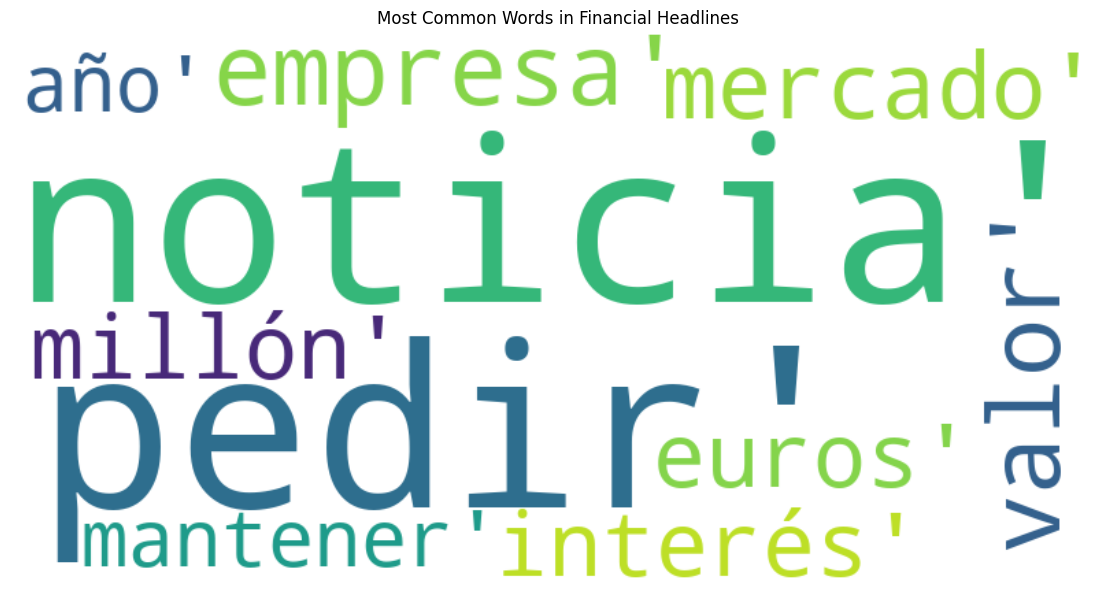

In [8]:
from wordcloud import WordCloud

# Find words that are common across all sentiments
all_words = set()
word_sentiment_data = {}

# Collect word sentiment data and filter out unimportant words
texts = texts_by_sentiment[sentiment]
words = get_meaningful_words_spacy(texts)     
# Count the frequency of each word
word_counts = Counter(words)
# Plot the word cloud
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white',
                      colormap='viridis',
                      max_words=100).generate(str(dict(word_counts)))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Financial Headlines')
plt.axis('off')
plt.tight_layout()
plt.show()


## 4. Analysis summary:

* The original dataset consists of 8,885 rows and 6 columns.
* We will focus on two columns for this analysis:
* 'text': a string containing financial news headlines in Spanish.
* 'target_sentiment': an integer representing sentiment classification.
* The dataset shows a balanced distribution between Positive and Negative sentiments, while the Neutral category is underrepresented. The percentage distribution is as follows:
    * Positive: 46.3%
    * Negative: 43.8%
    * Neutral: 9.9%

* The most frequent words in the headlines are:
    * noticia (36)
    * pedir (35)
    * empresa (34)
    * valor (28)
    * mercado (27)
    * interés (22)
    * millón (21)
    * euros (18)
    * mantener (18)
